In [1]:
from datetime import datetime
import sys

import geohashlite
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

In [2]:
trip = pd.read_csv("data/Taxi_Trips_-_2021.csv")

# parse data
trip['Trip Start Timestamp'] = trip['Trip Start Timestamp'].map(lambda x: datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p") if pd.notnull(x) else None)
trip['Trip End Timestamp'] = trip['Trip End Timestamp'].map(lambda x: datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p") if pd.notnull(x) else None)

# Data Cleaning 

In [3]:
def filter_outlier(df, colname, percentile=0.02, clip=(-sys.maxsize, sys.maxsize)):
    """
    clip: (lower bound, upper bound) to clip the values
    
    Filter out outliers
    Lower outer fence = Q1 - k * IQR
    Upper outer fence = Q3 + k * IQR
    """
    k = 6
    value = df[colname]
    q1, q3 = np.nanpercentile(value, [25, 75])
    iqr = q3-q1
    lower_outer_fence = max(clip[0], q1 - k * iqr)
    upper_outer_fence = min(clip[1], q3 + k * iqr)
    
    print(f"Trimming extreme values in column `{colname}`: below {round(lower_outer_fence, 2)}, or larger than {round(upper_outer_fence, 2)}")
    out_df = df.loc[(df[colname] < upper_outer_fence) & 
                    (df[colname] > lower_outer_fence)].copy()
    return out_df

In [4]:
# remove rows w/o fare labels 
trip_cleaned = trip.loc[~trip.Fare.isnull()].copy() 

# filter extreme outlier (high tendency of data entry error)
trip_cleaned = filter_outlier(trip_cleaned, "Fare", clip=(0, sys.maxsize))
trip_cleaned = filter_outlier(trip_cleaned, "Trip Miles", clip=(0, sys.maxsize)) # clip left
trip_cleaned = filter_outlier(trip_cleaned, "Trip Seconds", clip=(0, sys.maxsize)) # clip left

Trimming extreme values in column `Fare`: below 0, or larger than 170.0
Trimming extreme values in column `Trip Miles`: below 0, or larger than 65.24
Trimming extreme values in column `Trip Seconds`: below 0, or larger than 8608.0


***

# Feature Engineering

In [5]:
def get_geohash(lat, lon, precision=7):
    """
    Convert latitude, longitude to geohash
    """
    if pd.notnull(lat) and pd.notnull(lat):
        return geohashlite.encode(lat,lon ,precision)
    else:
        return None

## Feature: Demand score
Reminder: Ensure no data leak (aggregated data score should not appear in test period)

In [6]:
def gen_demand_score(df):
    """
    Generate the table for demand_score(day_of_week, hour, geohash)
        > higher score means higher demand
    """
    print("Generating demand score ...")
    
    REQUIRED_COLS = ["Trip ID", "Pickup Centroid Latitude", "Pickup Centroid Longitude", "Trip Start Timestamp"]
    assert all(c in df.columns for c in REQUIRED_COLS), f"Did not have all the required columns: {REQUIRED_COLS}"
    
    # transform table to get the necessary metadata
    df = df.loc[:, REQUIRED_COLS].dropna().copy()
    df['day_of_week'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%w")))
    df['hour'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%-H")))
    df['geohash'] = df.apply(lambda x: get_geohash(x['Pickup Centroid Latitude'], x['Pickup Centroid Longitude']),axis=1)
    
    # aggregate to get scores 
    pickup_demand_score = df.groupby(["day_of_week", "hour", "geohash"])['Trip ID'].count().reset_index(name="num_trips") # 
    pickup_demand_score['demand_score'] = (pickup_demand_score.num_trips - pickup_demand_score.num_trips.mean()) / pickup_demand_score.num_trips.std() # normalise
    
    return pickup_demand_score

In [10]:
# sanity check
gen_demand_score(trip_cleaned.sample(frac=0.05)).sort_values("demand_score", ascending=False).head()

Generating demand score ...


,day_of_week,hour,geohash,num_trips,demand_score
1304,0,19,dp3qz6r,276,10.487691
1379,0,20,dp3qz6r,271,10.288883
1222,0,18,dp3qz6r,261,9.891267
10079,5,16,dp3wmge,258,9.771982
10176,5,17,dp3wmge,254,9.612936


## Feature: Supply score

In [8]:
def gen_supply_score(df):
    """
    Generate the table for supply_score(day_of_week, hour, geohash)
        > higher means supply is higher
    """
    print("Generating supply score ...")
    
    REQUIRED_COLS = ["Taxi ID", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Start Timestamp"]
    assert all(c in df.columns for c in REQUIRED_COLS), f"Did not have all the required columns: {REQUIRED_COLS}"
    
    # transform table to get the necessary metadata
    df = df.loc[:, ["Taxi ID", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Start Timestamp"]].dropna().copy()
    df['day_of_week'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%w")))
    df['hour'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%-H")))
    df['geohash'] = df.apply(lambda x: get_geohash(x['Dropoff Centroid Latitude'], x['Dropoff Centroid Longitude']),axis=1)
    
    # aggregate to get scores 
    pickup_supply_score = df.groupby(["day_of_week", "hour", "geohash"])['Taxi ID'].agg(n_drivers=lambda x: len(set(x))).reset_index()
    pickup_supply_score['supply_score'] = (pickup_supply_score.n_drivers - pickup_supply_score.n_drivers.mean()) / pickup_supply_score.n_drivers.std() # normalise
    
    return pickup_supply_score

Generating supply score ...
   hour  day_of_week  geohash  n_drivers  supply_score
0     0            6  dp3wvp8         94      5.026376
1     1            6  dp3wvp8         78      4.071988
2     2            6  dp3wvp8         62      3.117600
3     3            6  dp3wvp8         32      1.328123
4     4            6  dp3wvp8         27      1.029877


Text(0.5, 1.0, 'Supply Score')

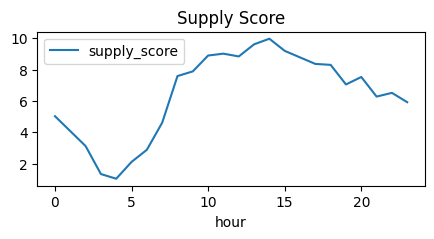

In [17]:
# sanity check
temp = gen_supply_score(trip_cleaned.sample(frac=0.05)).groupby("hour").max().reset_index()
print(temp.head())

temp['hour'] = temp.hour.astype(int)
plt.rcParams["figure.figsize"] = (5,2)
temp.sort_values("hour").plot.line(x='hour', y='supply_score')
plt.title("Supply Score")

Observation:
* Scores seems reasonable - peaked during working hour and dropped during midnight

## Feature: Traffic score 
Reminder: Ensure no data leak (aggregated data score should not appear in test period)

In [18]:
def gen_traffic_score(df):
    """
    Generate the table for traffic_score(day_of_week, hour)
        > higher means traffic is less congested
        
    P/S: Extension work - call Maps API to get the route from pickup to dropoff (so that traffic can be scored on a roadID level)
    """
    print("Generating traffic score ...")
    
    REQUIRED_COLS = ["Trip ID", "Trip Start Timestamp", "Trip Seconds", "Trip Miles"]
    assert all(c in df.columns for c in REQUIRED_COLS), f"Did not have all the required columns: {REQUIRED_COLS}"
    
    # transform table to get the necessary metadata
    df = df.loc[:, REQUIRED_COLS].dropna().copy()
    df = df.loc[df['Trip Seconds']!=0, ]
    df['day_of_week'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%w")))
    df['hour'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%-H")))
    df['avg_trip_speed'] = df['Trip Miles'] / df['Trip Seconds']

    
    # aggregate to get scores 
    traffic_score = df.groupby(["day_of_week", "hour"])\
    .agg(n_samples = ("avg_trip_speed", "count"), traffic_score = ("avg_trip_speed", "mean")).reset_index()
    
    # filter out states w/o sufficient samples
    traffic_score = traffic_score.loc[traffic_score.n_samples >= 30, traffic_score.columns!="n_samples"].reset_index(drop=True)
    
    return traffic_score

In [21]:
# sanity check
gen_traffic_score(trip_cleaned.sample(frac=0.05)).sort_values("traffic_score", ascending=False).head()

Generating traffic score ...


,day_of_week,hour,traffic_score
149,6,5,0.036008
46,1,22,0.020970
95,3,23,0.015931
121,5,1,0.014406
84,3,12,0.012402


****

# Modelling

In [22]:
def add_trip_score(df, demand_score, supply_score, traffic_score):
    """
    Add demand, supply, traffic scores to a booking info.
    """
    
    BOOKING_COLS = ["Trip Start Timestamp", "Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude"]
    assert all(c in df.columns for c in BOOKING_COLS), f"Did not have all the required columns: {BOOKING_COLS}"
    
    # transform to get required metadata
    df = df.copy()
    df['day_of_week'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%w")))
    df['hour'] = df['Trip Start Timestamp'].map(lambda x: int(datetime.strftime(x,"%-H")))
    df['pickup_geohash'] = df.apply(lambda x: get_geohash(x['Pickup Centroid Latitude'], x['Pickup Centroid Longitude']),axis=1)
    df['dropoff_geohash'] = df.apply(lambda x: get_geohash(x['Dropoff Centroid Latitude'], x['Dropoff Centroid Longitude']),axis=1)
    
    # left join to add scores
    df = pd.merge(df, demand_score, 
                  left_on=["day_of_week", "hour", "pickup_geohash"], right_on=["day_of_week", "hour", "geohash"], how="left")
    df = pd.merge(df, supply_score, 
                  left_on=["day_of_week", "hour", "pickup_geohash"], right_on=["day_of_week", "hour", "geohash"], how="left")
    df = pd.merge(df, traffic_score, 
                  on=["day_of_week", "hour"], how="left")
    
    # impute missing values 
    mean_demand_score = demand_score['demand_score'].mean()
    mean_supply_score = supply_score['supply_score'].mean()
    mean_traffic_score = traffic_score['traffic_score'].mean()
    
    df['demand_score'] = df.demand_score.fillna(mean_demand_score)
    df['supply_score'] = df.supply_score.fillna(mean_demand_score)
    df['traffic_score'] = df.traffic_score.fillna(mean_demand_score)
    
    return df

In [23]:
feat_cols_baseline = ["Trip Miles", "day_of_week", "hour"]
feat_cols_v1 = ["Trip Miles","day_of_week", "hour", "demand_score", "supply_score", "traffic_score"]

cv_mse_baseline = []
cv_mse_v1 = []

tscv = TimeSeriesSplit(n_splits=5, )
trip_cleaned = trip_cleaned.sort_values("Trip Start Timestamp").reset_index(drop=True)

# training-testing for 5 CV folds 
for i, (train_index, test_index) in enumerate(tscv.split(trip_cleaned)):
    print(f"---- Train-test for CV Fold {i+1} -----")
    ############### Training ###############
    train = trip_cleaned.iloc[train_index, :]
    
    # create score table
    demand_score_table = gen_demand_score(train)
    supply_score_table = gen_supply_score(train)
    traffic_score_table = gen_traffic_score(train)
    
    # add demand, supply, traffic score
    train = add_trip_score(train, demand_score_table, supply_score_table, traffic_score_table)
    
    # model training
    X_train = train.loc[:, :]
    y_train = train.loc[:, "Fare"]
    
    # fit
    # [v0] baseline 
    model_baseline = XGBRegressor()
    model_baseline.fit(X_train.loc[:, feat_cols_baseline], y_train)
    
    # [v1] (with supply, demand, traffic scores)
    model_v1 = XGBRegressor()
    model_v1.fit(X_train.loc[:, feat_cols_v1], y_train)
    
    ############### Testing ############### 
    test = trip_cleaned.iloc[test_index, :]
    
    # add demand, supply, traffic score
    test = add_trip_score(test, demand_score_table, supply_score_table, traffic_score_table)
    
    # model testing
    X_test = test.loc[:, :]
    y_test = test.loc[:, "Fare"]
    
    y_pred_baseline = model_baseline.predict(X_test.loc[:, feat_cols_baseline])
    y_pred_v1 = model_v1.predict(X_test.loc[:, feat_cols_v1])
    
    cv_mse_baseline.append(mean_squared_error(y_test, y_pred_baseline))
    cv_mse_v1.append(mean_squared_error(y_test, y_pred_v1))

---- Train-test for CV Fold 1 -----
Generating demand score ...
Generating supply score ...
Generating traffic score ...
---- Train-test for CV Fold 2 -----
Generating demand score ...
Generating supply score ...
Generating traffic score ...
---- Train-test for CV Fold 3 -----
Generating demand score ...
Generating supply score ...
Generating traffic score ...
---- Train-test for CV Fold 4 -----
Generating demand score ...
Generating supply score ...
Generating traffic score ...
---- Train-test for CV Fold 5 -----
Generating demand score ...
Generating supply score ...
Generating traffic score ...


# Results & Error Analysis

In [24]:
res_df = pd.DataFrame()
res_df['baseline'] = cv_mse_baseline
res_df['v1'] = cv_mse_v1
res_df['cv_fold'] = list(range(1, res_df.shape[0] + 1))

res_df = pd.melt(res_df, id_vars=['cv_fold'], value_vars=['baseline', 'v1']).rename({"value": "mse"}, axis=1)

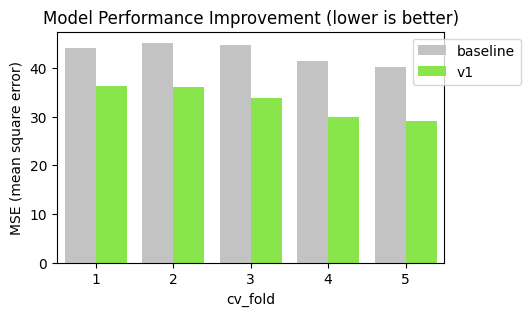

In [27]:
palette = {
    'baseline': '#C3C3C3',
    'v1':'#83FF33'
}

plt.rcParams["figure.figsize"] = (5,3)
sns.barplot(res_df, x='cv_fold', y='mse', hue="variable", palette=palette)
plt.title("Model Performance Improvement (lower is better)")
plt.ylabel("MSE (mean square error)")
plt.legend(bbox_to_anchor= (0.9, 1.0))
plt.savefig("figure/model_performance.png", bbox_inches="tight")

**Observation**
1. v1 model is consistently better than baseline
2. Downward trend as data increase